In [47]:
import importlib
import Preprocessing 
import Plotting
import Optimization
from matpowercaseframes import CaseFrames
import numpy as np
import pandas as pd
from Utilities_python import genfuel


importlib.reload(Preprocessing)
from Preprocessing import process_generation_data, fix_bus_numbers, map_generators_to_buses, map_loads_to_buses, make_bus_susceptance_matrix

## Load case_path## Load caseframe
case_path = './case_ACTIVSg2000.m'
cf = CaseFrames(case_path)

baseMVA = cf.baseMVA
NB = len(cf.bus)
NG = len(cf.gen)
NL = len(cf.branch)

c = cf.gencost['COST_1'].reset_index(drop=True)
cf.gen = cf.gen.reset_index(drop=True)
cf.gen['genfuel'] = genfuel
cf.gen['cost'] = c

## Fix bus numbers
cf.gen = fix_bus_numbers(cf.gen, cf.bus['BUS_I'], cf.bus,'GEN_BUS')
cf.branch = fix_bus_numbers(cf.branch, cf.bus['BUS_I'], cf.bus, 'F_BUS')
cf.branch = fix_bus_numbers(cf.branch, cf.bus['BUS_I'], cf.bus, 'T_BUS')

## Define maximum and minimum generation limits
min_p_mw = cf.gen['PMIN'].reset_index(drop=True)/baseMVA
max_p_mw = cf.gen['PMAX'].reset_index(drop=True)/baseMVA

map_generators = map_generators_to_buses(cf.gen, cf.gen['new_bus'], NB)
map_loads, len_loads = map_loads_to_buses(cf.bus, baseMVA)
congestion_factor = 1
b, branch_cap = make_bus_susceptance_matrix(cf.branch, baseMVA, congestion_factor, NB)


min_p_mw = cf.gen['PMIN'].reset_index(drop=True)/baseMVA
max_p_mw = cf.gen['PMAX'].reset_index(drop=True)/baseMVA

loads = cf.bus['PD']/baseMVA


In [ ]:
import Optimization 
importlib.reload(Preprocessing)
from Preprocessing import process_generation_data, fix_bus_numbers, map_generators_to_buses, map_loads_to_buses, make_bus_susceptance_matrix, max_green_max_black, max_green_max_black_nuclear_black

## Run for generating different amounts of green vs black generators in the grid. Generate generation data with the ratio of green vs black renewable generators 
map_green_generators, map_black_generators, generation, green_generation, black_generation, max_green, max_black = process_generation_data(max_p_mw, cf.gen, cf.gencost, NB)
ratio_green = 0.5
randomseed = 10

generation = max_green_max_black(generation, ratio_green, randomseed)

In [48]:
import Optimization 
importlib.reload(Preprocessing)
from Preprocessing import process_generation_data, fix_bus_numbers, map_generators_to_buses, map_loads_to_buses, make_bus_susceptance_matrix, max_green_max_black, max_green_max_black_nuclear_black

## Run for original data of system
map_green_generators, map_black_generators, generation, green_generation, black_generation, max_green, max_black = process_generation_data(max_p_mw, cf.gen, cf.gencost, NB, generation = generation)

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: 13th Gen Intel(R) Core(TM) i7-1355U, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 1 rows, 2544 columns and 2544 nonzeros
Model fingerprint: 0xb78c041d
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [3e-01, 3e+01]
  Bounds range     [7e-04, 1e+01]
  RHS range        [0e+00, 0e+00]
Presolve removed 0 rows and 1279 columns
Presolve time: 0.02s
Presolved: 1 rows, 1265 columns, 1265 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    9.6044152e+03   3.698102e+01   0.000000e+00      0s
       1    6.8859819e+03   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.02 seconds (0.00 work units)
Optimal objective  6.885981924e+03
45655.08999999997
45655.08999999998
Market clearing price for maximizing producer surplus: 14.170151703771898
Producer surplus: 190101.

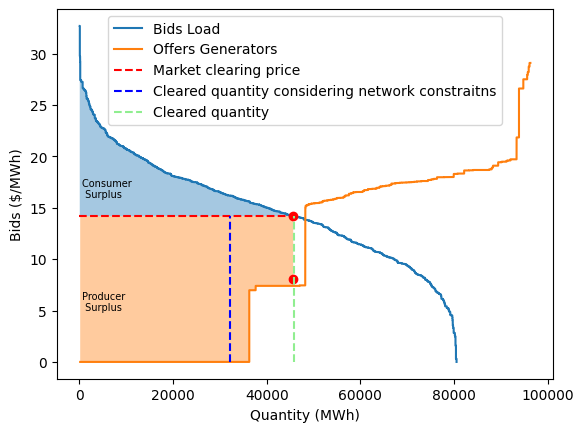

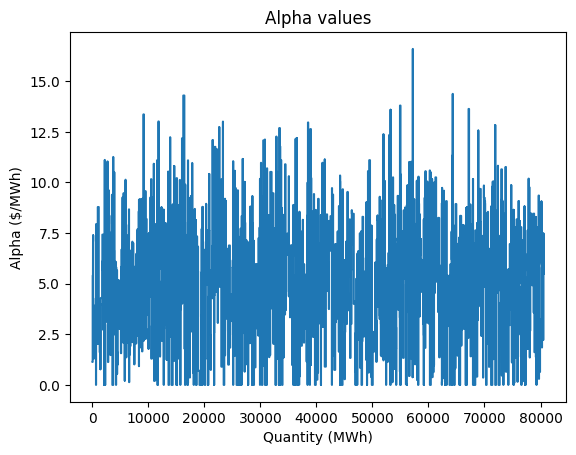

In [54]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

random.seed(10)
# generate load bids
load_bids = np.random.normal(loc=15, scale=5, size=2000)
load_bids = np.maximum(load_bids, 0)


alpha = np.random.normal(loc=5, scale=3, size=2000)
alpha = np.maximum(alpha, 0)

# alpha = np.zeros(2000)
bids = pd.DataFrame()
bids['bids'] = load_bids
bids['alpha'] = alpha
bids['max_load'] = 1.2*cf.bus['PD'].reset_index(drop=True)


bids_sorted = bids.sort_values(by='bids',ascending=False)
bids_sorted['accumulated load'] = bids_sorted['max_load'].cumsum() 
bids_sorted['accumulated alpha'] = bids_sorted['alpha'].cumsum()

# generate generator offers
gen_bids = pd.DataFrame()
gen_bids['offers'] = generation['c'].reset_index(drop=True)
gen_bids['genfuel'] = generation['genfuel'].reset_index(drop=True)

gen_bids['max_p_mw'] = max_p_mw*baseMVA
gen_bids_sorted = gen_bids.sort_values(by='offers')
gen_bids_sorted['accumulated offers'] = gen_bids_sorted['max_p_mw'].cumsum() 
plt.step(bids_sorted['accumulated load'], bids_sorted['bids'], where = 'post',label = 'Bids Load')
plt.step(gen_bids_sorted['accumulated offers'], gen_bids_sorted['offers'], where ='post', label ='Offers Generators')


# optimization problem for finding equilibrium
import gurobipy as gp
from gurobipy import GRB
model = gp.Model()
load_bids = bids_sorted['bids'].reset_index(drop=True)
gen_offers = gen_bids_sorted['offers'].reset_index(drop=True)
pg = [model.addVar(vtype=GRB.CONTINUOUS, lb=0, ub=max_p_mw[g], name=f"pg{g}") for g in range(len(gen_offers))]
pl = [model.addVar(vtype=GRB.CONTINUOUS, lb=0, ub=loads[g], name=f"pl{g}") for g in range(len(load_bids))]
obj = (gp.quicksum(load_bids[g]*pl[g] for g in range(len(load_bids)))-gp.quicksum(gen_offers[g]*pg[g] for g in range(len(gen_offers))))
model.setObjective(obj, gp.GRB.MAXIMIZE)


model.addConstr(gp.quicksum(pg[g] for g in range(len(gen_offers)))-gp.quicksum(pl[g] for g in range(len(load_bids)))==0)

model.update()
# model.printStats()
model.optimize()

pg_ = []
for i in range(len(gen_offers)):
    # print(f'pg{i}:', pg[i].X)
    pg_.append(pg[i].X)
    # print(constraints[i].Pi)
pg_=np.array(pg_)

pl_ = []
for i in range(len(load_bids)):
    # print(f'pg{i}:', pg[i].X)
    pl_.append(pl[i].X)
    # print(constraints[i].Pi)
pl_=np.array(pl_)

print(sum(pl_)*baseMVA)
print(sum(pg_)*baseMVA)

sum_pg = np.sum(pg_) * baseMVA

# Find the index of the first occurrence where accumulated offers exceed sum of generation values
closest_index = np.argmax(gen_bids_sorted['accumulated offers'] > sum(pg_)*baseMVA)
closest_index_bids = np.argmin(bids_sorted['accumulated load'] < sum(pl_)*baseMVA)
idx_gen_bids = gen_bids_sorted['offers'].iloc[closest_index+1]

# Plot both curves, generators and loads
plt.plot(sum(pl_)*baseMVA, bids_sorted['bids'].iloc[closest_index_bids], 'ro')
plt.plot(sum(pl_)*baseMVA, idx_gen_bids, 'ro')


plt.xlabel('Quantity (MWh)')
plt.ylabel('Bids ($/MWh)')

print('Market clearing price for maximizing producer surplus:', bids_sorted['bids'].iloc[closest_index_bids])
MCP = bids_sorted['bids'].iloc[closest_index_bids]
MCV = bids_sorted['accumulated load'].iloc[closest_index_bids]
# MCV = sum(pl_)*baseMVA

producer_surplus = sum(bids_sorted['bids'].iloc[:closest_index_bids]*bids_sorted['max_load'].iloc[:closest_index_bids])-MCP*MCV
consumer_surplus = MCP*MCV-sum(gen_bids_sorted['offers'].iloc[:closest_index]*gen_bids_sorted['max_p_mw'].iloc[:closest_index])

print('Producer surplus:', producer_surplus)
print('Consumer surplus:', consumer_surplus)

social_welfare = producer_surplus+consumer_surplus

print('Social welfare:', social_welfare)

# Fill in cleared quantity for using network constraints
cleared_quantity_constraints = 321.91355639702425*100

# Plot lines for clearing price and clearing volume and cleared volume using network constraints 
# Plot areas of consumer and producer surplus

plt.hlines(y=MCP, xmin=0, xmax=MCV, color='r', linestyle='--', label='Market clearing price')
plt.vlines(x=cleared_quantity_constraints, ymin = 0, ymax =MCP, color= 'b', linestyle = '--', label = 'Cleared quantity considering network constraitns')
plt.vlines(x=MCV, ymin = 0, ymax =MCP, color= 'lightgreen', linestyle = '--', label = 'Cleared quantity')
plt.legend()
plt.fill_between(bids_sorted['accumulated load'][:closest_index_bids],bids_sorted['bids'][:closest_index_bids], MCP, step="pre", alpha=0.4, label='Consumer Surplus')
plt.fill_between(gen_bids_sorted['accumulated offers'][:closest_index], MCP, gen_bids_sorted['offers'][:closest_index], step="post", alpha=0.4, label = 'Producer Surplus')
plt.text(500, 16, 'Consumer \n Surplus', fontsize = 7)
plt.text(500, 5, 'Producer \n Surplus', fontsize = 7)

plt.show()


plt.step(bids_sorted['accumulated load'], bids_sorted['alpha'], where = 'post')
plt.xlabel('Quantity (MWh)')
plt.ylabel('Alpha ($/MWh)')
plt.title('Alpha values')

sliced_df = gen_bids_sorted.iloc[:closest_index-1] #is the last one fully dispatched??

last_gen_dispatch = MCV - gen_bids_sorted['accumulated offers'].iloc[closest_index-1]


# # Filter the sliced DataFrame based on the condition
# filtered_df_green = sliced_df[sliced_df['genfuel'].isin(["wind", "hydro", "solar", "nuclear"])]
# filtered_df_black = sliced_df[sliced_df['genfuel'].isin(["ng", "coal"])]

# # Sum the values in the 'generation' column of the filtered DataFrame
# total_generation_green = filtered_df_green['max_p_mw'].sum()
# total_generation_black = filtered_df_black['max_p_mw'].sum()

# last_gen = gen_bids_sorted.iloc[closest_index]
# if gen_bids_sorted['genfuel'][closest_index] in ["wind", "hydro", "solar", "nuclear"]:
#     total_generation_green = total_generation_green+ last_gen_dispatch
# else:
#     total_generation_black= total_generation_black + last_gen_dispatch

# print('Green generation dispatch:',total_generation_green)
# print('Black generation dispatch:', total_generation_black)


Run optimization algorithm to find the LMPs

In [55]:
importlib.reload(Optimization)
from Optimization import max_social_welfare_black_green_LMPs_v3
# bids = pd.read_csv('bids_case1.csv')
load_bid = bids['bids'].reset_index(drop=True)


alpha= np.random.normal(loc=5, scale=3, size=2000)
alpha = np.maximum(alpha, 0)
# alpha= np.zeros(2000)

model, theta, pg_green, pg_black, pl_green, pl_black, balance_constraint, green_balance= max_social_welfare_black_green_LMPs_v3(alpha, load_bid,green_generation, black_generation, max_green, max_black, map_black_generators, map_green_generators, map_loads, len_loads, loads, b, branch_cap, NB, ref_bus=0)


Statistics for model Unnamed:
  Linear constraint matrix    : 8461 Constrs, 11253 Vars, 29790 NZs
  Matrix coefficient range    : [ 1, 3055.68 ]
  Objective coefficient range : [ 0.007711, 32.6848 ]
  Variable bound range        : [ 0.0007, 87.04 ]
  RHS coefficient range       : [ 0.19, 43.52 ]
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: 13th Gen Intel(R) Core(TM) i7-1355U, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 8461 rows, 11253 columns and 29790 nonzeros
Model fingerprint: 0xe353e2ed
Coefficient statistics:
  Matrix range     [1e+00, 3e+03]
  Objective range  [8e-03, 3e+01]
  Bounds range     [7e-04, 9e+01]
  RHS range        [2e-01, 4e+01]
Presolve removed 4313 rows and 6116 columns
Presolve time: 0.03s
Presolved: 4148 rows, 5137 columns, 20056 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0      handle free variables            

Obtain the results from the optimization

In [56]:
import Optimization

importlib.reload(Optimization)
from Optimization import opt_results_black_green_LMPs_v3

theta_, pg_black_, pg_green_, pl_green_, pl_black_,  LMP_, lambda_green = opt_results_black_green_LMPs_v3(theta, pg_green, pg_black, pl_green, pl_black, balance_constraint, green_balance, green_generation, black_generation, len_loads, NB)

sum black gen = 0.08
sum green gen = 324.8888994056955
sum black load = 0.079999999834231880213586407535331090912222862243653
sum green load = 324.8888994056955


In [57]:
lambda_green

-0.0

In [50]:
import Optimization
importlib.reload(Optimization)
from Optimization import max_social_welfare_black_green_LMPs_v3, max_social_welfare_black_green_LMPs_v5
# bids = pd.read_csv('bids_case1.csv')
load_bid = bids['bids'].reset_index(drop=True)
alpha = bids['alpha'].reset_index(drop=True)
alpha=alpha = np.random.normal(loc=5, scale=1, size=2000)
alpha = np.maximum(alpha, 0)
#alpha= np.zeros(2000)

#model, theta, pg_green, pg_black, pl_green, pl_black,  black_balance_constraint, green_balance_constraint, green_balance= max_social_welfare_black_green_LMPs_v5(alpha, load_bid,green_generation, black_generation, max_green, max_black, map_black_generators, map_green_generators, map_loads, len_loads, loads, b, branch_cap, NB, ref_bus=0)
model, theta, pg_green, pg_black, pl_green, pl_black,  black_balance_constraint, green_balance_constraint, epsilon_balance, epsilon_green, epsilon_black, black_balance = max_social_welfare_black_green_LMPs_v5(alpha, load_bid,green_generation, black_generation, max_green, max_black, map_black_generators, map_green_generators, map_loads, len_loads, loads, b, branch_cap, NB, ref_bus=0)

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "C:\Users\emijo\AppData\Roaming\Python\Python38\site-packages\IPython\core\interactiveshell.py", line 3508, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\emijo\AppData\Local\Temp\ipykernel_13808\3426901775.py", line 12, in <module>
    model, theta, pg_green, pg_black, pl_green, pl_black,  black_balance_constraint, green_balance_constraint, epsilon_balance, epsilon_green, epsilon_black, black_balance = max_social_welfare_black_green_LMPs_v5(alpha, load_bid,green_generation, black_generation, max_green, max_black, map_black_generators, map_green_generators, map_loads, len_loads, loads, b, branch_cap, NB, ref_bus=0)
  File "c:\Users\emijo\OneDrive - Danmarks Tekniske Universitet\Dokumenter\GitHub\dualpricing\Optimization.py", line 685, in max_social_welfare_black_green_LMPs_v5
  File "c:\Users\emijo\OneDrive - Danmarks Tekniske Universitet\Dokumenter\GitHub\dualpricing\Optimization.py", line 687, in <dictcomp>

In [58]:
## Emissions
import Preprocessing
importlib.reload(Preprocessing)
from Preprocessing import *

map_wind_generators, map_solar_generators, map_hydro_generators, map_coal_generators, map_nuclear_generators, map_ng_generators = process_generation_data_emissions(max_p_mw, cf.gen, cf.gencost, NB, generation = generation)
avg_emissions_per_MWh, emisisons_green, emissions_black = get_emissions(pg_green_, pg_black_, map_wind_generators, map_solar_generators, map_hydro_generators, map_coal_generators, map_nuclear_generators, map_ng_generators, baseMVA =100)

avg_emissions_per_MWh, emisisons_green, emissions_black

(127.1485116155384, 41264.1118807738, 55.2)

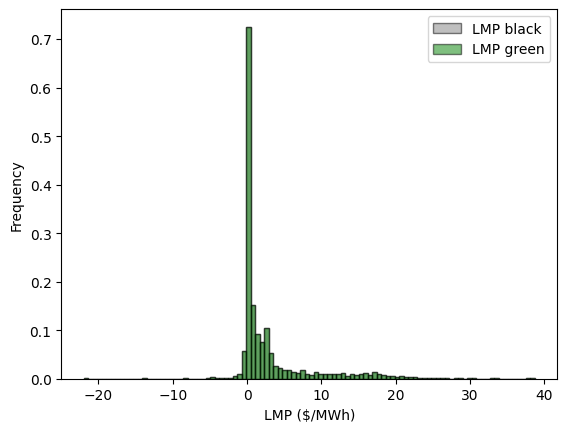

In [59]:
# plt.hist(np.array(LMP_), bins= 100)
import matplotlib.pyplot as plt
n, bins, patches = plt.hist(np.array(LMP_), 100, density=True, facecolor='grey',edgecolor='black', alpha=0.5, lw=1, label='LMP black')
n, bins, patches = plt.hist(np.array(LMP_)+lambda_green, 100, density=True, facecolor='g', edgecolor='black',alpha=0.5, lw=1, label='LMP green')
plt.xlabel('LMP ($/MWh)')
plt.ylabel('Frequency')
plt.legend()

Plotting

In [68]:
import geopandas as gpd
from shapely.geometry import Point, Polygon
import pandas as pd

import Plotting 

importlib.reload(Plotting)
from Plotting import dfs_for_plotting

## Run a few times for the driver to work
gpd.io.file.fiona.drvsupport.supported_drivers['KML'] = 'rw'
ercot_coords = gpd.read_file('./ercot_data/ercot_coords.kml', driver='KML')
type(ercot_coords)

bus = cf.bus
bus_index = 'BUS_I'
df_map_LMPs, df_green_LMPs, ercot_coords = dfs_for_plotting(ercot_coords, bus, bus_index, LMP_, lambda_green)



AttributeError: 'NoneType' object has no attribute 'drvsupport'

In [67]:
import importlib
import Plotting
import folium
importlib.reload(Plotting)
from Plotting import *
importlib.reload(Plotting)
from Plotting import plot_lines, plot_LMPs_black, compute_line_loadings
line_loading, overloaded_lines = compute_line_loadings(congestion_factor, theta_, cf.branch,baseMVA, NL)

vmin = min(np.array(LMP_).min(), (np.array(LMP_)+np.array(lambda_green)).min())  # Min value across both DataFrames
vmax = max(np.array(LMP_).max(), (np.array(LMP_)+np.array(lambda_green)).max())

from_bus = cf.branch['new_from_bus']
to_bus = cf.branch['new_to_bus']
map_center = [31.9686, -99.9018]
# map = folium.Map(location=map_center, zoom_start=4)
map = folium.Map(location=map_center,tiles="CartoDB Positron", zoom_start=6)
map = plot_lines_folium(map, ercot_coords, from_bus, to_bus, line_loading)
# map = plot_LMPs_folium(map, ercot_coords, LMP_, vmin, vmax)
#map = plot_LMPs_folium(map, ercot_coords, np.array(LMP_)+lambda_green, vmin, vmax)
map = plot_LMPs_folium_only_red_orange(map, ercot_coords, np.array(LMP_)+lambda_green,vmin, vmax)



# map = plot_alpha_folium(map, ercot_coords, alpha)
# map = plot_green_black_gen_folium(map, ercot_coords, generation)
# map = plot_green_not_dispatched(map, ercot_coords,  green_generation,pg_green_)
# map = plot_green_black_LMPs_folium(map, ercot_coords, LMP_, lambda_green,vmin, vmax)


# map, merged_df = plot_load_bids_folium(map, ercot_coords, bus, load_bid, alpha, NB, baseMVA)
# map = plot_green_LMPs_folium(map, ercot_coords, LMP_, lambda_green, vmin, vmax)
# map_center = [31.9686, -99.9018]
# map = folium.Map(location=map_center, zoom_start=4)

map

NameError: name 'ercot_coords' is not defined

In [155]:
map.save("map_50RES_greenLMPs.html")

In [84]:
overloaded_lines

39

In [221]:
np.mean(LMP_)

13.735384411758343